In [1]:
%load_ext autoreload
%autoreload 2

## Loading Libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from pathlib import Path

from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

import torchvision

import PIL

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Loading path and reading in data

In [3]:
path = Path('data/kaggle_mnist/'); path.ls()

[PosixPath('data/kaggle_mnist/train.csv'),
 PosixPath('data/kaggle_mnist/test.csv'),
 PosixPath('data/kaggle_mnist/submission.csv')]

In [4]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')

In [6]:
# Helper function
def convert_to_img(arr):
    px = arr.values
    reshaped_pix = px.reshape(-1, 28, 28)
    reshaped_pix = np.stack((reshaped_pix, ) * 3, axis=1)
    tensor_pix = torch.tensor(reshaped_pix, dtype=torch.float) / 255
    
    images = [vision.image.Image(tensor) for tensor in tensor_pix]
    
    return images

## Initializing data and target

In [7]:
# Splitting data
data, target = convert_to_img(train.iloc[:, 1:]), train.iloc[:,0].values
train_X, val_X, train_y, val_y = train_test_split(data, target, test_size=0.2)

In [8]:
# Custom PixelImageList class
class PixelImageList(ImageList):
    def get(self, i):
        img = self.items[i]
        self.sizes[i] = img.size
        return img

In [9]:
# LabelLists for training and valid
tx = PixelImageList(train_X)
ty = CategoryList(train_y, classes=list(map(str,range(10))))
vx = PixelImageList(val_X)
vy = CategoryList(val_y, classes=list(map(str, range(10))))

tll = LabelList(tx, ty)
vll = LabelList(vx, vy)

lls = LabelLists(path=".", train=tll, valid=vll)

In [10]:
# Test list
test_list = PixelImageList(convert_to_img(test))


# add test list to lls
lls.add_test(items=test_list)

LabelLists;

Train: LabelList (33600 items)
x: PixelImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,9,6,4,6
Path: .;

Valid: LabelList (8400 items)
x: PixelImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,4,3,7,9
Path: .;

Test: LabelList (28000 items)
x: PixelImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: .

## Prepare data for model

First create a databunch

In [31]:
bs = 64

In [32]:
tfms = get_transforms(do_flip=False)
data = (ImageDataBunch.create_from_ll(lls, bs=bs//2, ds_tfms=tfms, num_workers=0, size=28)
                      .normalize(mnist_stats))

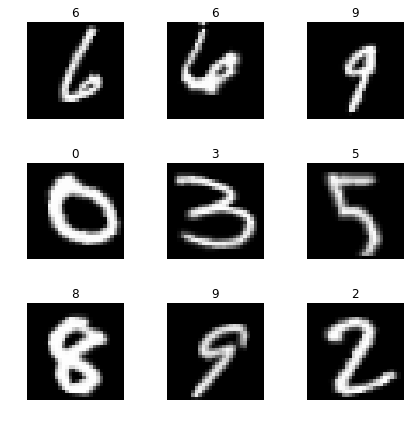

In [33]:
data.show_batch(3, figsize=(6, 6))


## Training model with ResNet50

In [50]:
learn2 = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


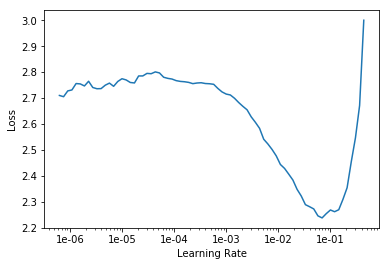

In [51]:
learn2.lr_find()
learn2.recorder.plot()

In [52]:
learn2.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.313133,0.150218,0.045476,01:10
1,0.228601,0.106430,0.030833,01:10
2,0.134745,0.093902,0.027976,01:08
3,0.070598,0.028199,0.008452,01:09
4,0.052907,0.096105,0.010238,01:10


In [53]:
learn2.save('mnist50-stage1')

In [54]:
learn2.load('mnist50-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: PixelImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,9,6,4,6
Path: .;

Valid: LabelList (8400 items)
x: PixelImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,4,3,7,9
Path: .;

Test: LabelList (28000 items)
x: PixelImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: ., model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [55]:
learn2.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


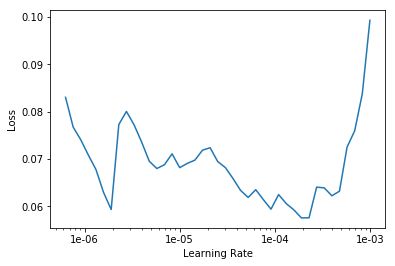

In [56]:
learn2.lr_find()
learn2.recorder.plot()

In [57]:
learn2.fit_one_cycle(5, max_lr=slice(3e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.067910,0.068896,0.014167,01:18
1,0.045283,0.027040,0.008095,01:19
2,0.041680,0.052702,0.009762,01:17
3,0.039414,0.017786,0.005476,01:19
4,0.023427,0.017064,0.005238,01:19


## Interpretation from ClassificationInterpretation Object

In [58]:
interp50 = ClassificationInterpretation.from_learner(learn2)

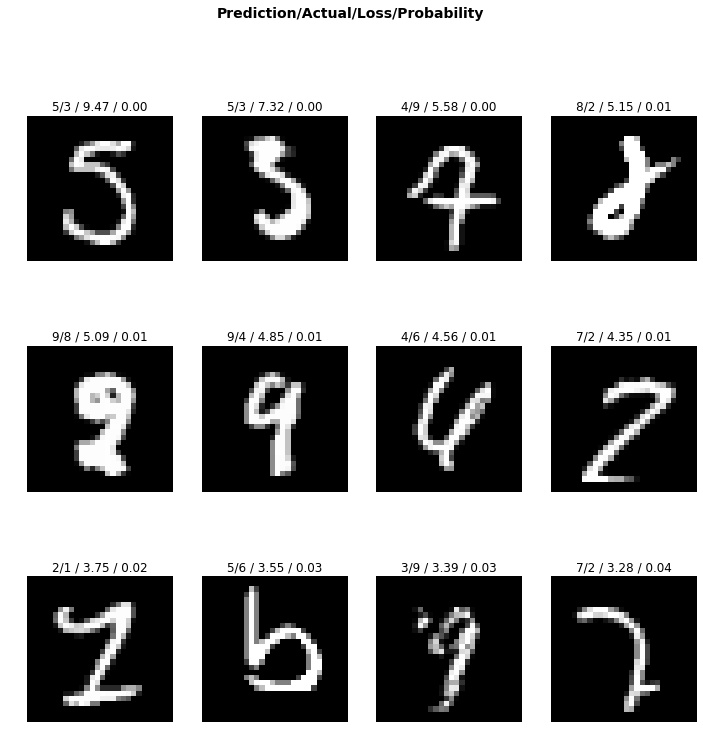

In [59]:
interp50.plot_top_losses(12)

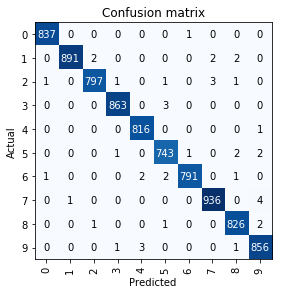

In [60]:
interp50.plot_confusion_matrix()

In [61]:
interp50.most_confused(min_val=2)

[('7', '9', 4),
 ('2', '7', 3),
 ('3', '5', 3),
 ('9', '4', 3),
 ('1', '2', 2),
 ('1', '7', 2),
 ('1', '8', 2),
 ('5', '8', 2),
 ('5', '9', 2),
 ('6', '4', 2),
 ('6', '5', 2),
 ('8', '9', 2)]

## Test Predictions

In [62]:
predictions = learn2.get_preds(ds_type=DatasetType.Test)

In [63]:
submission = pd.DataFrame({'ImageId': list(range(1, len(predictions[0]) + 1)), 'Label':predictions[0].argmax(1)})
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [64]:
submission.to_csv(path/'submission.csv', index=False)